In [2]:
from burstextractor.burstlist import download_burst_list, process_burst_list
from burstextractor.timeutils import extract_time, fix_typos_in_time, fix_24_hour_time, create_datetime, check_valid_date, adjust_year_month
from burstextractor.data_utils import explode_instruments_long_clean_instruments, keep_only_type_I_to_VI
from spectogram_utils import spec_to_pd_dataframe, plot_spectogram
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
from radiospectra.sources import CallistoSpectrogram

In [3]:
burst_list = pd.read_excel('burst_list.xlsx')
burst_list.sample(5)

,date,time,type,instruments,time_start,time_end,date_start,date_end,datetime_start,datetime_end
10410,20220511,01:59-02:04,III,ALASKA-HAARP,01:59,02:04,20220511,20220511,2022-05-11 01:59:00,2022-05-11 02:04:00
7456,20220328,11:24-12:35,IV,AUSTRIA-MICHELBACH,11:24,12:35,20220328,20220328,2022-03-28 11:24:00,2022-03-28 12:35:00
6849,20220306,07:58-07:59,III,INDIA-GAURI,07:58,07:59,20220306,20220306,2022-03-06 07:58:00,2022-03-06 07:59:00
20116,20221208,09:29-09:30,III,SWISS-Landschlacht,09:29,09:30,20221208,20221208,2022-12-08 09:29:00,2022-12-08 09:30:00
13044,20220628,05:26-05:29,III,EGYPT-Alexandria,05:26,05:29,20220628,20220628,2022-06-28 05:26:00,2022-06-28 05:29:00


In [60]:
IMAGE_FOLDER = 'images'
IMAGE_LEN = pd.Timedelta('30m')
# CallistoSpectrogram.from_range('ALASKA-ANCHORAGE', '2023-01-01T20:00:00', '2023-01-02T04:50:00')

def download_spectogram(df_row, mid_time, duration, subtract_background=True):
    spec = CallistoSpectrogram.from_range(df_row['instruments'], mid_time - duration / 2,  mid_time + duration / 2)
    spec = spec.remove_border()
    if subtract_background:
        spec = spec.subtract_bg()
    spec = spec_to_pd_dataframe(spec, df_row)
    spec = spec[mid_time - duration / 2:mid_time + duration / 2]
    return spec

def download_spectogram_from_df_row(df_row, duration):
    mid_time = df_row['datetime_start'] + (df_row['datetime_end'] - df_row['datetime_start']) / 2
    return download_spectogram(df_row, mid_time, duration)

In [61]:
spec = download_spectogram_from_df_row(burst_list.iloc[5], IMAGE_LEN)

In [63]:
spec.content

'2021/01/20  Radio flux density, e-CALLISTO (SWISS-Landschlacht)'

In [56]:
spec.attrs['sunflare_level'] = 0

In [57]:
spec.attrs['sunflare_level']

0

In [33]:
burst_list.iloc[5]

date                         20210120
time                      12:37-12:37
type                              III
instruments        SWISS-Landschlacht
time_start                      12:37
time_end                        12:37
date_start                   20210120
date_end                     20210120
datetime_start    2021-01-20 12:37:00
datetime_end      2021-01-20 12:37:00
Name: 5, dtype: object

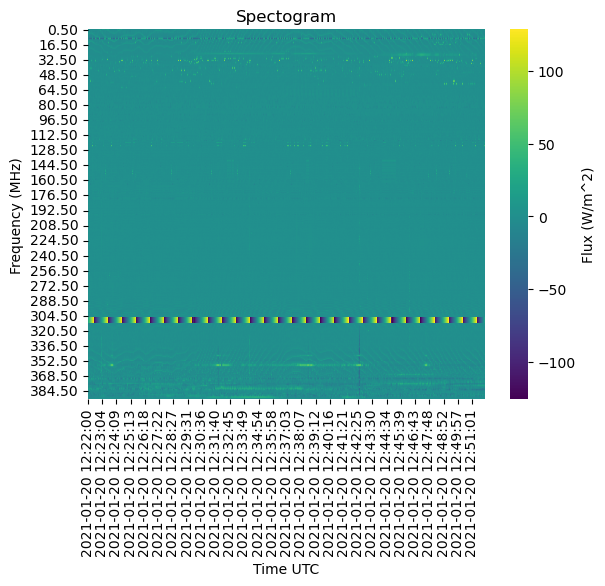

In [53]:
plot_spectogram(spec)

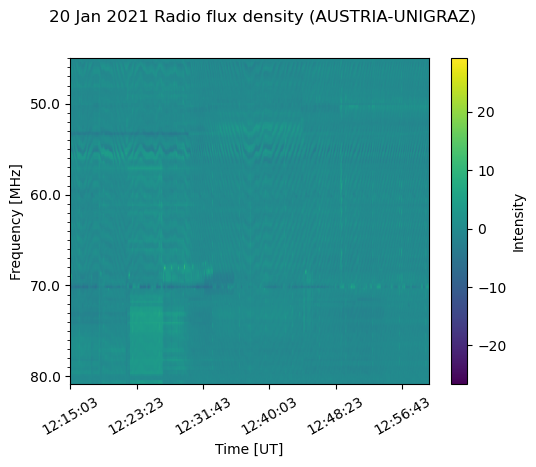

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [ ]:
spec.subtract_bg().peek()